## Initialize the application data layer

We will start with application data. In GourmetGram, this is the transactional data for users, images, comments, and flags, all of which supports the business logic and UI that real users interact with.

Our data repository will be PostgreSQL: it is great for application reads and writes, and for representing current state of the application

Here is a system view for the application phase (this notebook + the next notebook):

<figure>
<img src="images/application-components.png" alt="Application architecture" />
<figcaption aria-hidden="true">Application architecture</figcaption>
</figure>

In this notebook, we bring up:

-   PostgreSQL: relational database for application state
-   Adminer: browser UI to inspect PostgreSQL tables
-   MinIO + MinIO init: object storage for uploaded images, and an init job that sets up buckets

and prepare some database tables, but they will initially be empty. In the next notebook, we will add:

-   `api_v1` (FastAPI): application endpoints for users/uploads/comments/views/flags
-   `data_generator`: synthetic client traffic into those endpoints
-   extract/transform helper services: one-time job, prepares the image samples that will be used for synthetic uploads
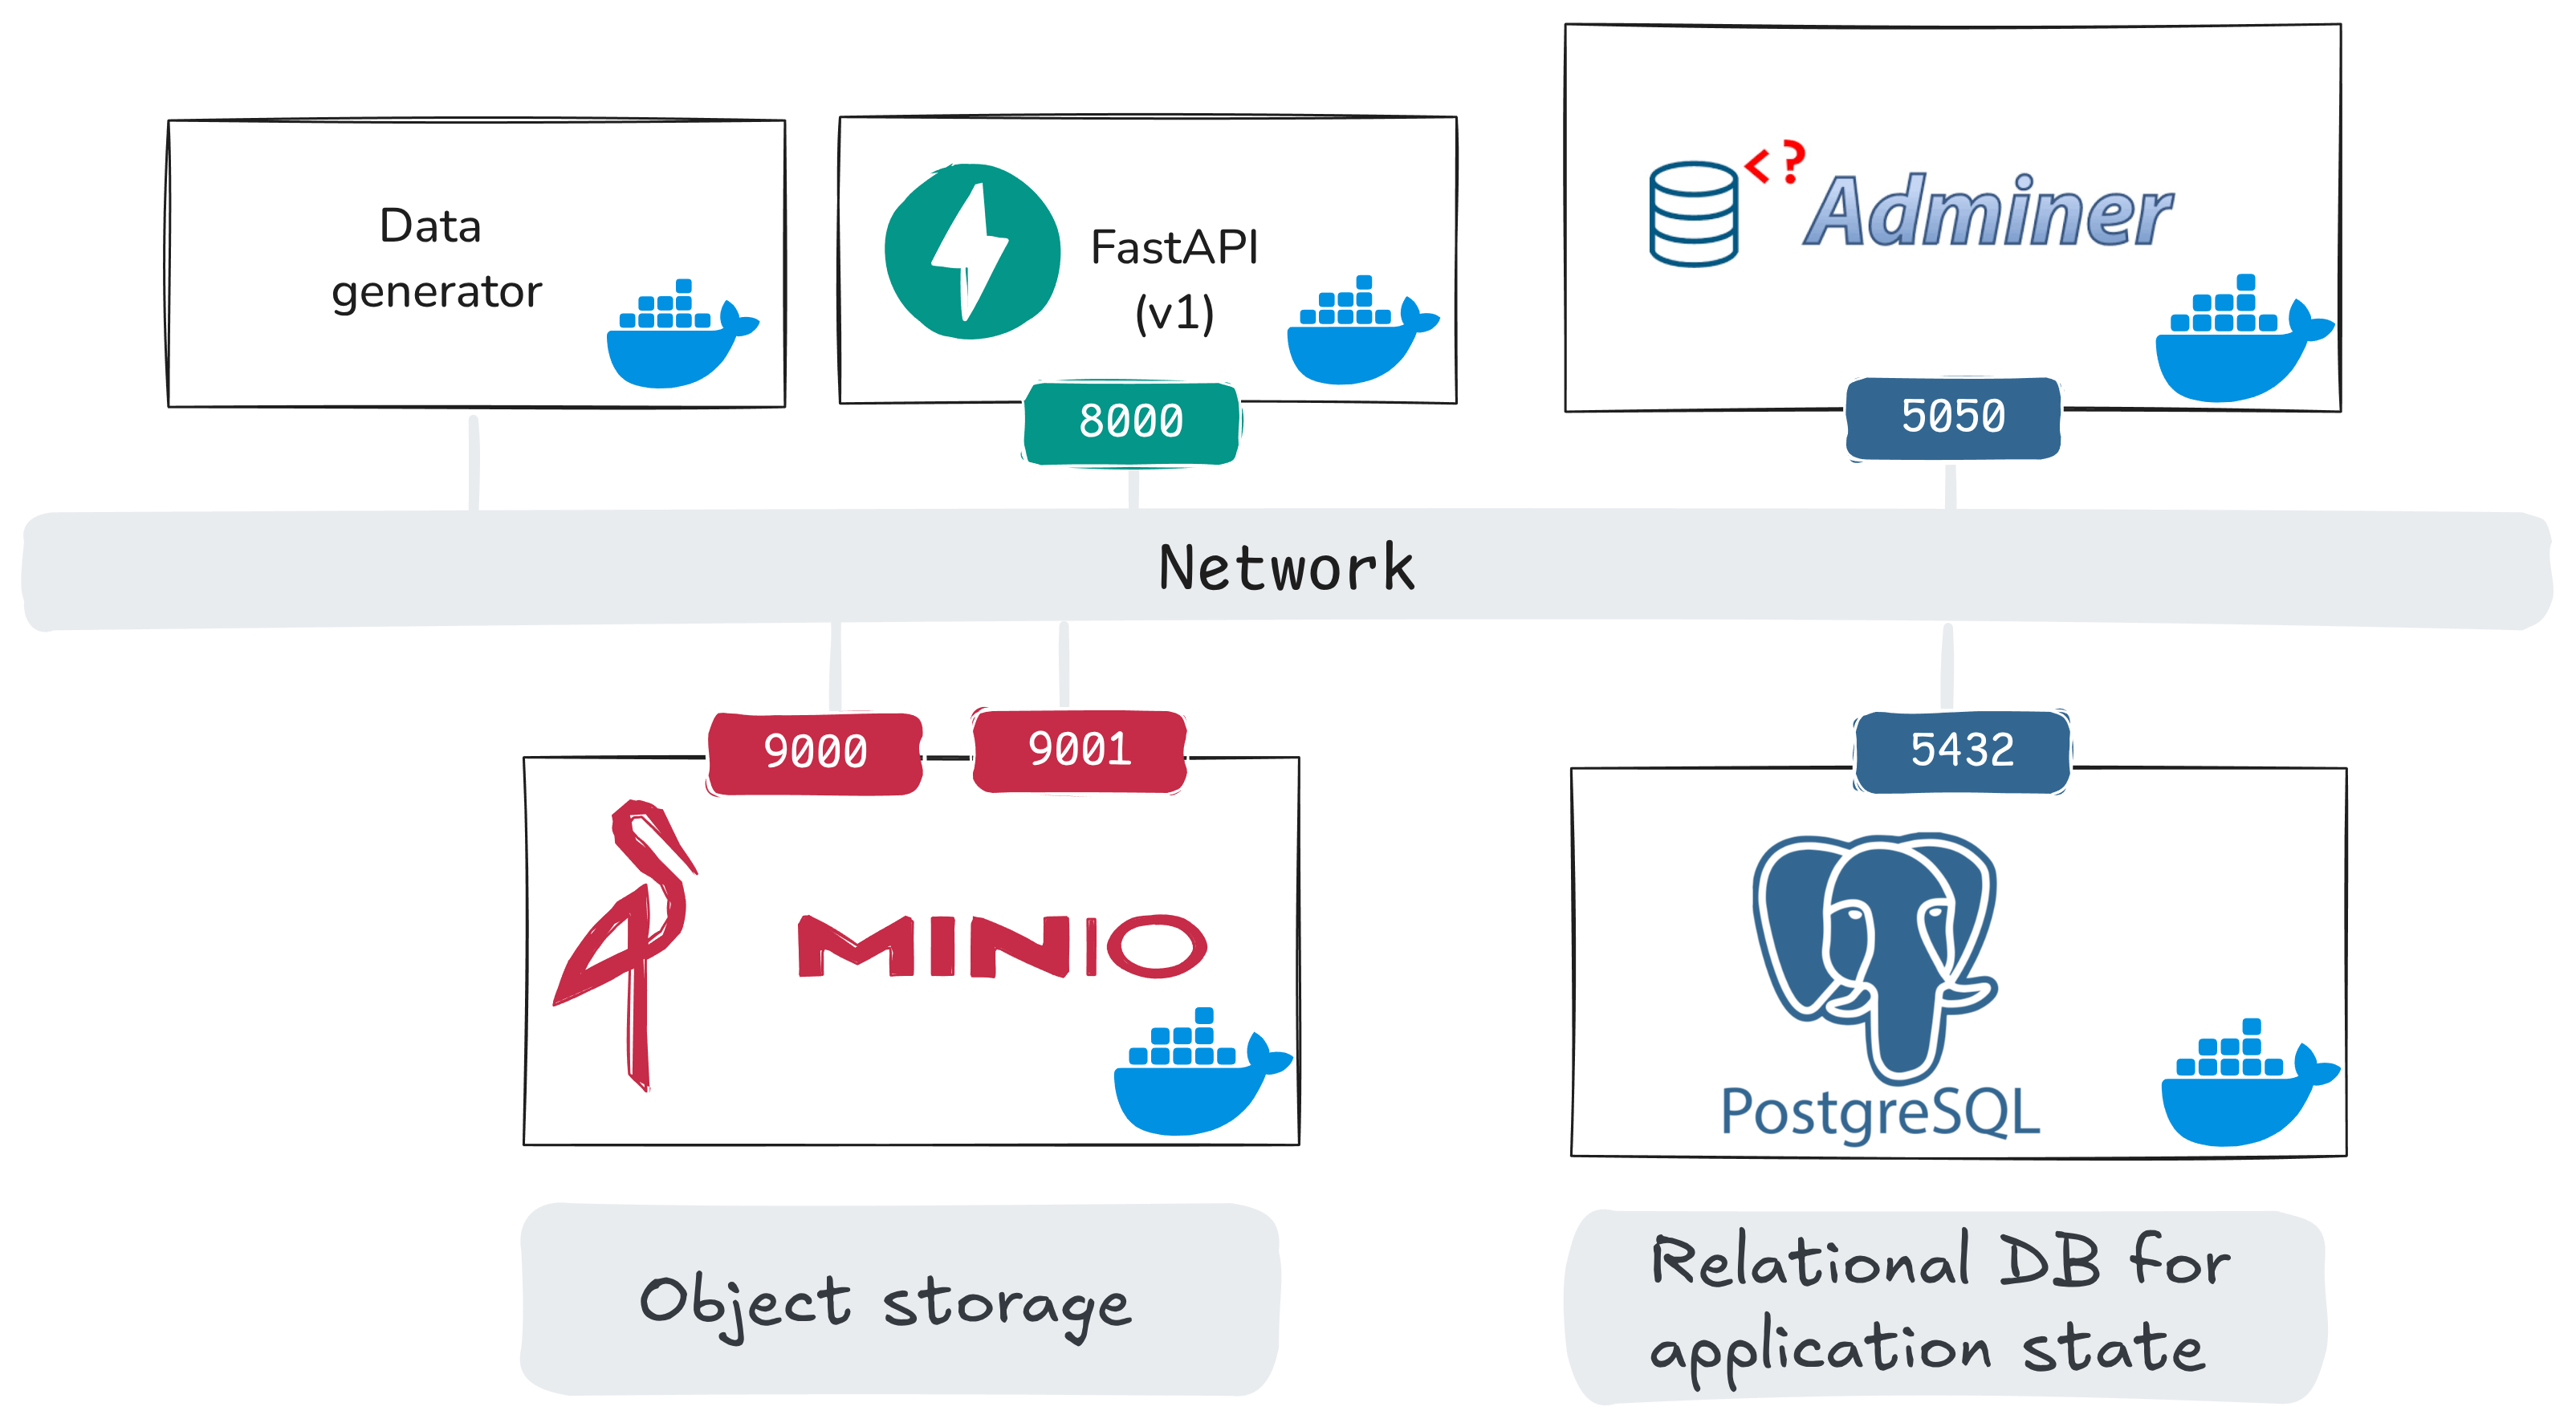

Before we start services, let’s inspect the PostgreSQL service definition in `docker/docker-compose.yaml` in more detail:

``` yaml
postgres:
  image: postgres:18
  container_name: postgres
  environment:
    POSTGRES_USER: user
    POSTGRES_PASSWORD: gourmetgram_postgres
    POSTGRES_DB: gourmetgram
  ports:
    - "5432:5432"
  volumes:
    - postgres_data:/var/lib/postgresql
    - ./init_sql:/docker-entrypoint-initdb.d
  healthcheck:
    test: [ "CMD-SHELL", "pg_isready -U user -d gourmetgram" ]
```

Here,

-   `image`: selects the Postgres version used in this lab.
-   `environment`: sets database name and login credentials as environment variables. (We’ve hardcoded them for convenience, but in a real service you would not include these in the Compose file.)
-   `ports`: maps container Postgres port to VM port `5432`. Other services will access it on that port
-   `volumes`: keeps database data persistent (`postgres_data`) across container restarts, and mounts initialization SQL files (`./init_sql`) which we will use to set up tables when Postgres comes up.
-   `healthcheck`: lets dependent services wait until Postgres is ready.

Because `./init_sql` is mounted into `/docker-entrypoint-initdb.d`, Postgres runs those SQL files on first initialization. For example, this `images` table definition comes from `docker/init_sql/00_create_app_tables.sql`:

``` sql
CREATE TABLE IF NOT EXISTS images (
    id UUID PRIMARY KEY DEFAULT gen_random_uuid(),
    user_id UUID NOT NULL REFERENCES users(id),
    s3_url VARCHAR NOT NULL,
    source VARCHAR(32) NOT NULL DEFAULT 'user_upload',
    caption TEXT,
    category TEXT,
    created_at TIMESTAMPTZ DEFAULT NOW(),
    deleted_at TIMESTAMPTZ,
    views INTEGER DEFAULT 0,
    CHECK (source IN ('user_upload', 'synthetic', 'import'))
);
```

This schema gives each image a durable identifier, links it to a user (`user_id`), stores object location (`s3_url`), tracks app state for the image (`views`), and includes governance-oriented fields (`source`, `deleted_at`).

From your SSH session on the Chameleon VM, start only the database and the Adminer UI:

``` bash
# run on node-data
docker compose -f /home/cc/data-platform-chi/docker/docker-compose.yaml up -d postgres adminer
```

Check that both services are running:

``` bash
# run on node-data
docker ps
```

You should see `postgres` and `adminer` in `running` (or `healthy`) state.

## Browse PostgreSQL in the UI

Adminer is a browser-based UI for Postgres. Open it in your browser:

-   `http://A.B.C.D:5050`

where `A.B.C.D` is the floating IP address associated with your instance.

Use the following login values:

-   System: PostgreSQL (use the drop-down to change it!)
-   Server: `postgres`
-   Username: `user`
-   Password: `gourmetgram_postgres`
-   Database: `gourmetgram`

Then click Login.

After login, inspect the core application tables:

1.  Click one table name (for example `users`).
2.  Click “Show structure” to see the schema, and “Select data” to browse the data. Currently, these tables will all be empty.
3.  Repeat for `images`, `comments`, `flags`, and `moderation`.

Eventually, our application state will leave in these tables as follows:

-   `users`: account-level application state. This includes ToS fields for governance checks, `country_of_residence` for regional policy slices, and `is_test_account` to filter synthetic/internal accounts used for testing from analysis.
-   `images`: image records plus metadata. The `source` field helps us separate user content from synthetic content, and `deleted_at` allows for soft deletion.
-   `comments`: user-generated text attached to images. `moderator_hidden` and `moderator_action_id` let us track when content is hidden and which moderation action caused it.
-   `flags`: user reports of problematic content. `review_status`, `resolved_at`, and `moderation_action_id` are populated during the review workflow.
-   `moderation`: moderation outcomes for images/comments/accounts. `risk_score` is a risk value attached to the item by a model or a heuristic, `model_version` identifies which model produced it, and `inference_request_id` links related records from one inference request, so that we can audit ML-assisted moderation outcomes.

## Prepare object storage for uploads

Let’s also set up MinIO and create the required buckets. MinIO will store images that are uploaded to GourmetGram - we saw in the PostgreSQL `images` table that there is a field where we will put the image’s location in the object store.

Here’s the relevant compose section:

``` yaml
minio:
  image: minio/minio:RELEASE.2025-09-07T16-13-09Z
  container_name: minio
  command: server /data --console-address ":9001"
  environment:
    MINIO_ROOT_USER: admin
    MINIO_ROOT_PASSWORD: gourmetgram_minio
  ports:
    - "9000:9000"
    - "9001:9001"

minio-init:
  image: minio/mc:RELEASE.2025-08-13T08-35-41Z-cpuv1
  container_name: minio-init
  depends_on:
    minio:
      condition: service_healthy
  command: |
    mc alias set myminio http://minio:9000 admin gourmetgram_minio
    mc mb --ignore-existing myminio/gourmetgram-datalake
    mc mb --ignore-existing myminio/gourmetgram-images
```

Note that there is a minio-init job that creates two buckets, one for images and one that is used later in the lab.

Run:

``` bash
# run on node-data
docker compose -f /home/cc/data-platform-chi/docker/docker-compose.yaml up -d minio minio-init
```

Open the MinIO console at `http://A.B.C.D:9001` (use your floating IP in place of `A.B.C.D`). Log in with the credentials:

-   Username: `admin`
-   Password: `gourmetgram_minio`

After login:

1.  Click Object Browser in the left menu.
2.  Confirm that the bucket `gourmetgram-images` exists. (It was created by the minio-init job.)
3.  Click the bucket name and verify it is currently empty.

It does not yet have any images - but it will soon. In the next part, we will turn on API endpoints and synthetic traffic so that PostgreSQL tables and MinIO objects are populated with realistic application activity.